**Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории**

**Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.**

**В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.**

**Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.**

**В этом проекте у нас стоит задача персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.**


In [1]:
# код ервьюера
!pip install shap -q
!pip install --upgrade scikit-learn
!pip install --upgrade matplotlib==3.5.0

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
import seaborn as sns
import shap
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    r2_score, 
    mean_absolute_error,
    mean_squared_error,
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix
)
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [3]:
data_market_file = pd.read_csv('/datasets/market_file.csv')
data_market_money = pd.read_csv('/datasets/market_money.csv')
data_market_time = pd.read_csv('/datasets/market_time.csv')
data_money = pd.read_csv('/datasets/money.csv', sep=';', decimal = ',')

**Есть 4 датасета:
data_market_file - Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении**

**data_market_money - Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.**

**data_market_time - Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.**

**data_money - Таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.**

In [4]:
data_list = [data_market_file, data_market_money, data_market_time, data_money]

In [5]:
for i in data_list:
    display(i.info())
    display(i.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

None

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None

,id,Прибыль
0,215348,0.98
1,215349,4.16


In [6]:
data_list_cat_col = [
    'Покупательская активность',
    'Тип сервиса',
    'Разрешить сообщать',
    'Популярная_категория'
]
for i in data_list_cat_col:
    print(data_market_file[i].unique())
data_market_file['Тип сервиса'] = data_market_file['Тип сервиса'].str.replace('стандартт','стандарт')
print('Тип Сервиса без поправленный', data_market_file['Тип сервиса'].unique())

['Снизилась' 'Прежний уровень']
['премиум' 'стандартт' 'стандарт']
['да' 'нет']
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']
Тип Сервиса без поправленный ['премиум' 'стандарт']


In [7]:
data_market_money['Период'].unique()
print('Период поправленный', data_market_money['Период'].unique())

Период поправленный ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


In [8]:
data_market_time['Период'].unique()
data_market_time['Период'] = data_market_time['Период'].str.replace('предыдцщий_месяц','предыдущий_месяц')
print('Период поправленный', data_market_time['Период'].unique())

Период поправленный ['текущий_месяц' 'предыдущий_месяц']


**Завершили предобработку, избавились от данных, возникших судя по всему вследствии человеческого фактора. Пропуски обнаружены не были**

In [9]:
for i in data_list:
    print(i.duplicated().sum())

0
0
0
0


In [10]:
print(data_market_money[data_market_money.duplicated(keep=False)])
data_market_money = data_market_money.drop_duplicates()
print('После удаления дубликатов:', data_market_money.duplicated().sum())

Empty DataFrame
Columns: [id, Период, Выручка]
Index: []
После удаления дубликатов: 0


In [11]:
def col_name (df):
    new_column_names = {}
    for column in df.columns:
        new_name = column.replace(',', '_')
        new_name = column.replace(' ', '_')
        new_column_names[column] = new_name
    df.rename(columns=new_column_names, inplace=True)
    return df
for i in data_list:
    i = col_name(i)

In [12]:
data_market_file = pd.merge(
    data_market_file,
    data_money[['id']],
    on='id',
    how='inner'
)

**Дубликаты удалены, предобработка завершена, данные в порядке**

****ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ****

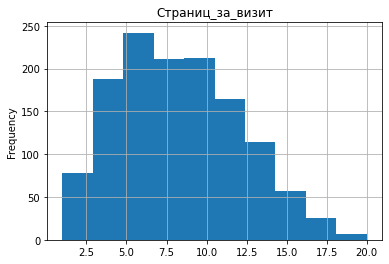

In [13]:
data_market_file['Страниц_за_визит'].plot(kind = 'hist', bins = 10, title='Страниц_за_визит', grid = True);

In [14]:
data_market_file['Страниц_за_визит'].value_counts()

6     127
5     115
4     112
8     109
9     108
10    104
7     102
11     92
3      76
12     73
13     61
2      58
14     53
15     36
16     21
1      20
17     19
18      7
19      5
20      2
Name: Страниц_за_визит, dtype: int64

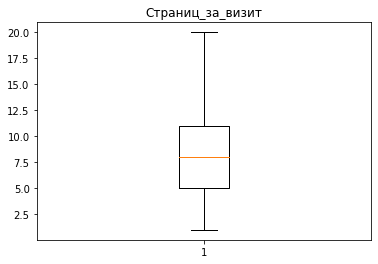

In [15]:
plt.boxplot(data_market_file['Страниц_за_визит'])
plt.title('Страниц_за_визит');

**Тут всё хорошо с данными**

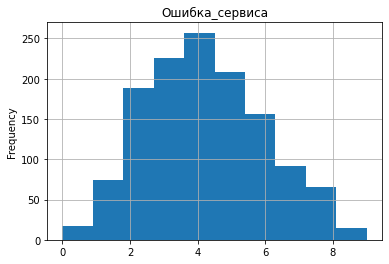

In [16]:
data_market_file['Ошибка_сервиса'].plot(kind = 'hist', bins = 10, title='Ошибка_сервиса', grid = True);

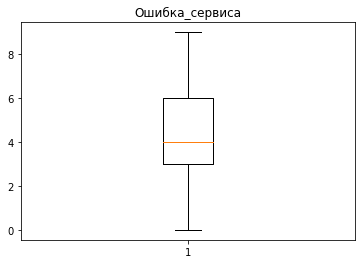

In [17]:
plt.boxplot(data_market_file['Ошибка_сервиса'])
plt.title('Ошибка_сервиса');

**Тоже всё в порядке, выбросов не наблюдается**

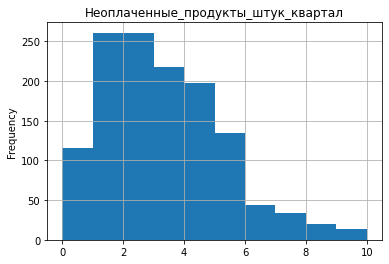

In [18]:
data_market_file['Неоплаченные_продукты_штук_квартал'].plot(kind = 'hist', bins = 10, title='Неоплаченные_продукты_штук_квартал', grid = True);

In [19]:
data_market_file['Неоплаченные_продукты_штук_квартал'].value_counts()

1     261
2     261
3     218
4     197
5     135
0     116
6      44
7      34
8      20
9      10
10      4
Name: Неоплаченные_продукты_штук_квартал, dtype: int64

**Аналогично предыдущему, данные впорядке**

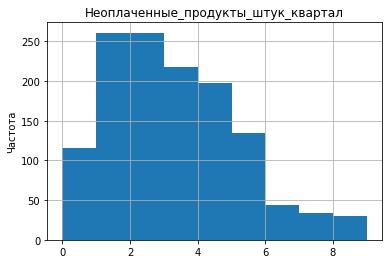

In [20]:
data_market_file = data_market_file.query('0 <= Неоплаченные_продукты_штук_квартал < 10')
data_market_file['Неоплаченные_продукты_штук_квартал'].plot(kind = 'hist',bins = 9, title='Неоплаченные_продукты_штук_квартал', grid = True);
plt.ylabel('Частота');

**Тут мы избавились от тех, кто держал в корзине 10 товаров и не оплачивал, скорее всего, они используют корзину как хранилище понравившихся вещей и вряд-лм будут оплачивать. А статистику попортить нам могут**

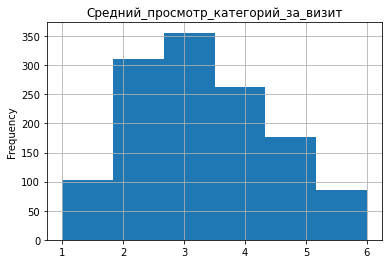

In [21]:
data_market_file['Средний_просмотр_категорий_за_визит'].plot(kind = 'hist', bins = 6, title='Средний_просмотр_категорий_за_визит', grid = True);

**В среднем, больше всего просматривают 3 категории за посещение**

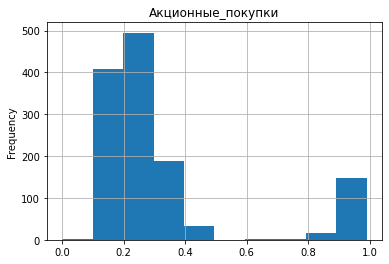

In [22]:
data_market_file['Акционные_покупки'].plot(kind = 'hist', bins = 10, title='Акционные_покупки', grid = True);

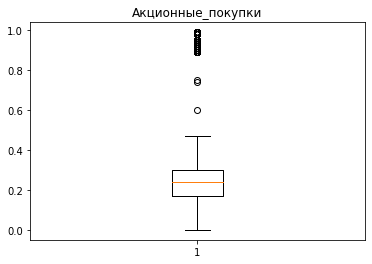

In [23]:
plt.boxplot(data_market_file['Акционные_покупки'])
plt.title('Акционные_покупки');

**Я бы не считал данные значения выбросами, есть покупатели, которые приобретают товар только по скидкам, а есть те, кому эти самые скидки не принципиальны. Всё зависит от дохода отдельно взятых людей**

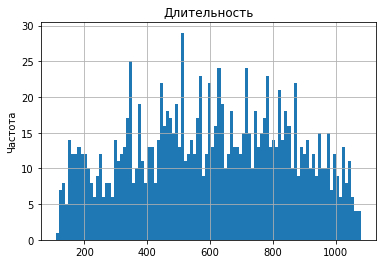

In [24]:
data_market_file['Длительность'].plot(kind = 'hist', bins = 100, title='Длительность', grid = True)
plt.ylabel('Частота');

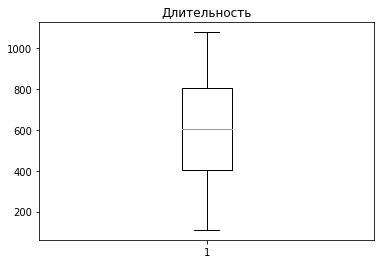

In [25]:
plt.boxplot(data_market_file['Длительность'])
plt.title('Длительность');

**Тут тоже всё хорошо**

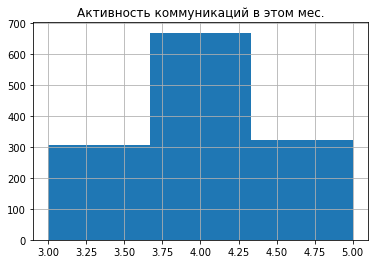

In [26]:
data_market_file['Маркет_актив_тек_мес'].hist(bins=3)
plt.title('Активность коммуникаций в этом мес.');

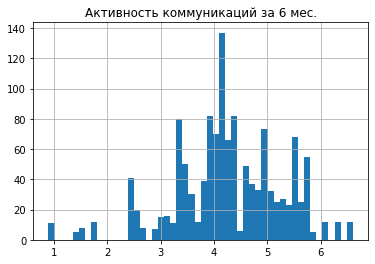

In [27]:
data_market_file['Маркет_актив_6_мес'].hist(bins=50)
plt.title('Активность коммуникаций за 6 мес.');

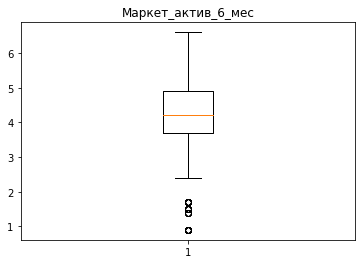

In [28]:
plt.boxplot(data_market_file['Маркет_актив_6_мес'])
plt.title('Маркет_актив_6_мес');

**Тут всё нормально, эти значения сложно считать выбросами, вполне вероятно, что клиент либо отказался от получения уведомлений, либо не брал трубки и тд. Вариантов много и всего они вполне себе могли случиться**

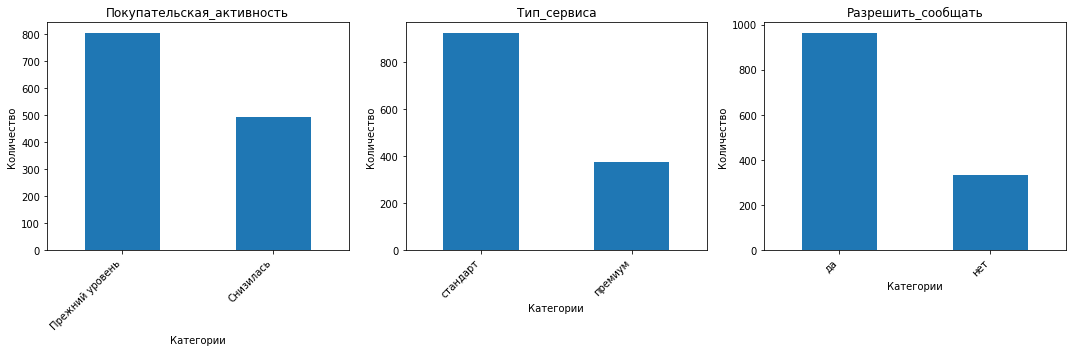

In [29]:
cat_columns = [
    'Покупательская_активность',
    'Тип_сервиса',
    'Разрешить_сообщать'
]
plt.figure(figsize=(15, 5))

for i, column in enumerate(cat_columns, 1):
    plt.subplot(1, 3, i)
    value_counts = data_market_file[column].value_counts()
    value_counts.plot(kind='bar')
    plt.title(column)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Категории')
    plt.ylabel('Количество')

plt.tight_layout()
plt.show()

**Тут можно наблюдать, что большая часть покупателей сохранили свою активность, так же большинство относятся к сервису стандарт и не против получать сообщения о акциях и предложениях**

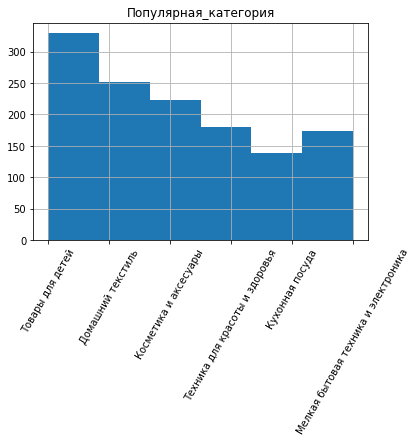

In [30]:
data_market_file['Популярная_категория'].hist(bins=6)
plt.xticks(rotation=60)
plt.title('Популярная_категория');

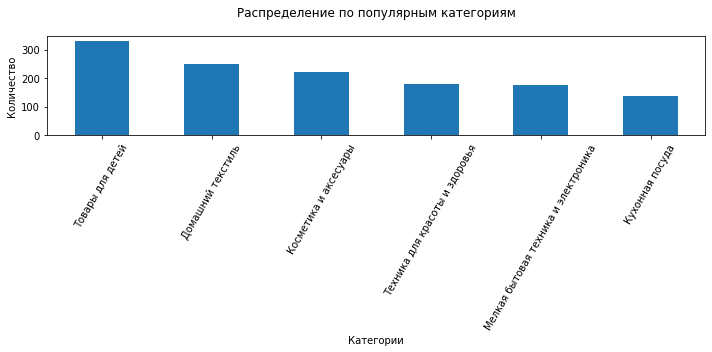

In [31]:
value_counts = data_market_file['Популярная_категория'].value_counts()
plt.figure(figsize=(10, 5))
value_counts.plot(kind='bar')
plt.title('Распределение по популярным категориям', pad=20)
plt.xlabel('Категории')
plt.ylabel('Количество')
plt.xticks(rotation=60)


plt.tight_layout()
plt.show()

**Больше всего пользуются спросом товары для детей**

In [32]:
data_market_money.head(2)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1


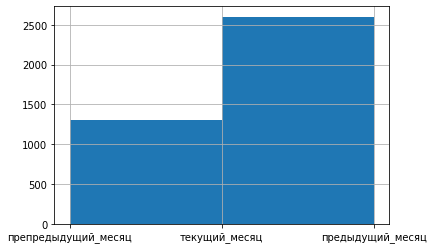

In [33]:
data_market_money['Период'].hist(bins=2);

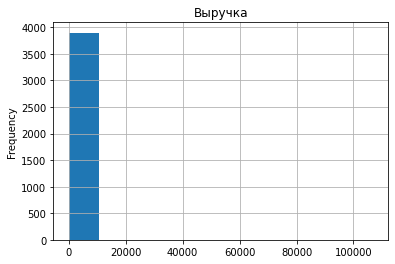

In [34]:
data_market_money['Выручка'].plot(kind = 'hist',bins = 10, title='Выручка', grid = True);

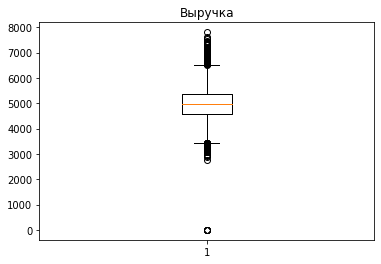

In [35]:
data_market_money = data_market_money.query('Выручка < 10000')
plt.boxplot(data_market_money['Выручка'])
plt.title('Выручка');

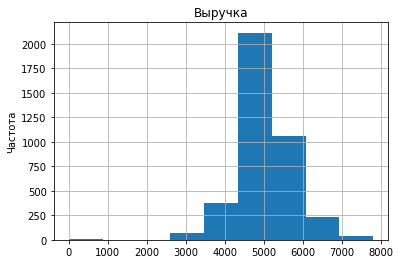

In [36]:
data_market_money = data_market_money.query('Выручка < 10000')
data_market_money['Выручка'].plot(kind = 'hist',bins = 9, title='Выручка', grid = True);
plt.ylabel('Частота');

**Такая картина более реальная, скорее всего были ошибки в системе, слишком большое (около 100т.р.) и очень маленькое (около 10р) значения убрали как выбросы**

In [37]:
data_market_time.head(2)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13


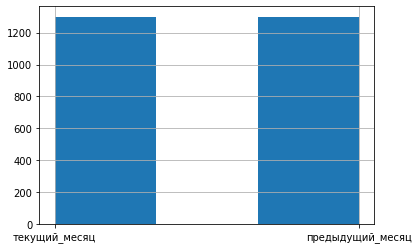

In [38]:
data_market_time['Период'].hist(bins=3);

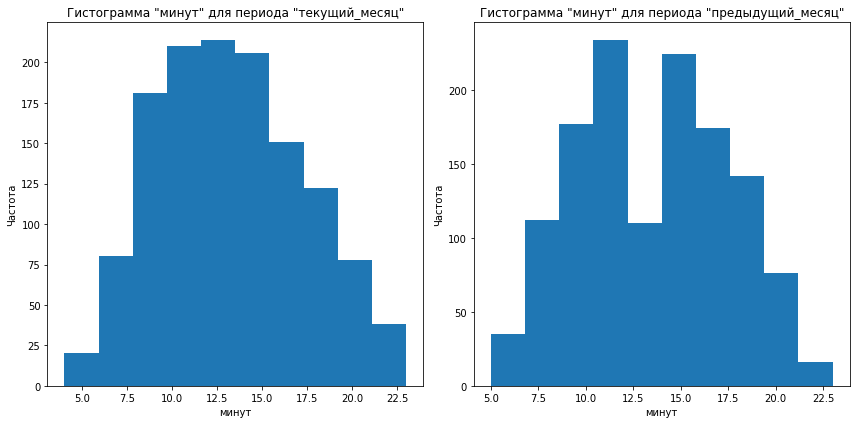

In [39]:
periods = data_market_time['Период'].unique()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for i, period in enumerate(periods):
    data_market_time[data_market_time['Период'] == period]['минут'].plot(kind='hist', bins=10, ax=ax[i], title=f'Гистограмма "минут" для периода "{period}"')

ax[0].set_xlabel('минут')
ax[0].set_ylabel('Частота')
ax[1].set_xlabel('минут')
ax[1].set_ylabel('Частота')
plt.tight_layout()
plt.show()

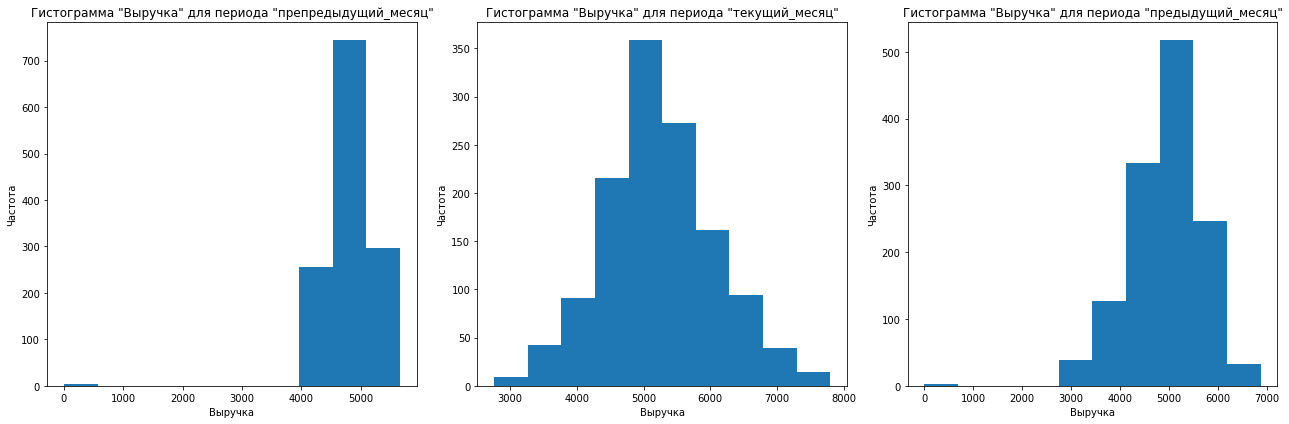

In [40]:
periods = data_market_money['Период'].unique()
n_periods = len(periods) 

fig, ax = plt.subplots(1, n_periods, figsize=(6 * n_periods, 6))

for i, period in enumerate(periods):
    data_market_money[data_market_money['Период'] == period]['Выручка'].plot(
        kind='hist', 
        bins=10, 
        ax=ax[i], 
        title=f'Гистограмма "Выручка" для периода "{period}"'
    )
    ax[i].set_xlabel('Выручка')
    ax[i].set_ylabel('Частота')

plt.tight_layout()
plt.show()

In [41]:
data_money.head(2)

,id,Прибыль
0,215348,0.98
1,215349,4.16


**Тут нормальное распределение, всё хорошо**

**ОБЪЕДИНЕНИЕ ТАБЛИЦ**

In [42]:
data_full = pd.merge(pd.merge(data_market_file, data_market_money, on='id', how='left'), data_market_time, on='id', how='left')
data_full

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Период_x,Выручка,Период_y,минут
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,препредыдущий_месяц,0.0,текущий_месяц,14
1,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,препредыдущий_месяц,0.0,предыдущий_месяц,13
2,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,текущий_месяц,3293.1,текущий_месяц,14
3,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,текущий_месяц,3293.1,предыдущий_месяц,13
4,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,предыдущий_месяц,0.0,текущий_месяц,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7769,216647,Прежний уровень,премиум,да,4.0,5,906,0.94,Техника для красоты и здоровья,4,5,3,12,предыдущий_месяц,4720.0,предыдущий_месяц,15
7770,216647,Прежний уровень,премиум,да,4.0,5,906,0.94,Техника для красоты и здоровья,4,5,3,12,препредыдущий_месяц,5183.0,текущий_месяц,10
7771,216647,Прежний уровень,премиум,да,4.0,5,906,0.94,Техника для красоты и здоровья,4,5,3,12,препредыдущий_месяц,5183.0,предыдущий_месяц,15
7772,216647,Прежний уровень,премиум,да,4.0,5,906,0.94,Техника для красоты и здоровья,4,5,3,12,текущий_месяц,4448.3,текущий_месяц,10


In [43]:
data_pivot = data_full.pivot_table(
    index='id',
    values='Выручка',
    columns='Период_x',
    aggfunc='sum'
).rename(columns={
    'предыдущий_месяц': 'предыдущий_месяц_выручка',
    'текущий_месяц': 'текущий_месяц_выручка',
    'препредыдущий_месяц': 'препредыдущий_месяц_выручка'
})

data_pivot1 = data_full.pivot_table(
    index='id',
    values='минут',
    columns='Период_x',
    aggfunc='sum'
).rename(columns={
    'предыдущий_месяц': 'предыдущий_месяц_минут',
    'текущий_месяц': 'текущий_месяц_минут',
    'препредыдущий_месяц': 'препредыдущий_месяц_минут'
})
data_full = data_full.join(data_pivot, on='id', how='left')
data_full = data_full.join(data_pivot1, on='id', how='left')
data_full

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,...,Период_x,Выручка,Период_y,минут,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,препредыдущий_месяц_минут,текущий_месяц_минут
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,...,препредыдущий_месяц,0.0,текущий_месяц,14,0.0,0.0,6586.2,27.0,27.0,27.0
1,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,...,препредыдущий_месяц,0.0,предыдущий_месяц,13,0.0,0.0,6586.2,27.0,27.0,27.0
2,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,...,текущий_месяц,3293.1,текущий_месяц,14,0.0,0.0,6586.2,27.0,27.0,27.0
3,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,...,текущий_месяц,3293.1,предыдущий_месяц,13,0.0,0.0,6586.2,27.0,27.0,27.0
4,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,...,предыдущий_месяц,0.0,текущий_месяц,14,0.0,0.0,6586.2,27.0,27.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7769,216647,Прежний уровень,премиум,да,4.0,5,906,0.94,Техника для красоты и здоровья,4,...,предыдущий_месяц,4720.0,предыдущий_месяц,15,9440.0,10366.0,8896.6,25.0,25.0,25.0
7770,216647,Прежний уровень,премиум,да,4.0,5,906,0.94,Техника для красоты и здоровья,4,...,препредыдущий_месяц,5183.0,текущий_месяц,10,9440.0,10366.0,8896.6,25.0,25.0,25.0
7771,216647,Прежний уровень,премиум,да,4.0,5,906,0.94,Техника для красоты и здоровья,4,...,препредыдущий_месяц,5183.0,предыдущий_месяц,15,9440.0,10366.0,8896.6,25.0,25.0,25.0
7772,216647,Прежний уровень,премиум,да,4.0,5,906,0.94,Техника для красоты и здоровья,4,...,текущий_месяц,4448.3,текущий_месяц,10,9440.0,10366.0,8896.6,25.0,25.0,25.0


In [44]:
data_full = data_full.drop(['Период_x', 'Период_y', 'минут','Выручка'], axis=1)

data_full = data_full.rename(columns={'предыдущий_месяц_x': 'предыдущий_месяц_выручка',
                                      'текущий_месяц_x': 'текущий_месяц_выручка',
                                     'предыдущий_месяц_y': 'предыдущий_месяц_минут',
                                     'текущий_месяц_y':'текущий_месяц_минут'})


In [45]:
data_full = data_full.drop_duplicates(subset='id')
data_full.duplicated().sum()

0

In [46]:
data_full = data_full.dropna()

In [47]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1295 entries, 0 to 7768
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1295 non-null   int64  
 1   Покупательская_активность            1295 non-null   object 
 2   Тип_сервиса                          1295 non-null   object 
 3   Разрешить_сообщать                   1295 non-null   object 
 4   Маркет_актив_6_мес                   1295 non-null   float64
 5   Маркет_актив_тек_мес                 1295 non-null   int64  
 6   Длительность                         1295 non-null   int64  
 7   Акционные_покупки                    1295 non-null   float64
 8   Популярная_категория                 1295 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1295 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1295 non-null   int64  
 11  Ошибка_сервиса                

**Объединив таблицы мы создали удобный ДФ для обработки. Так же мы ограничили его клиентами, которые проявляли свою покупательную активность в последние 3 месяца**


**КОРРЕЛЯЦИОННЫЙ АНАЛИЗ**

<Figure size 2160x2160 with 0 Axes>

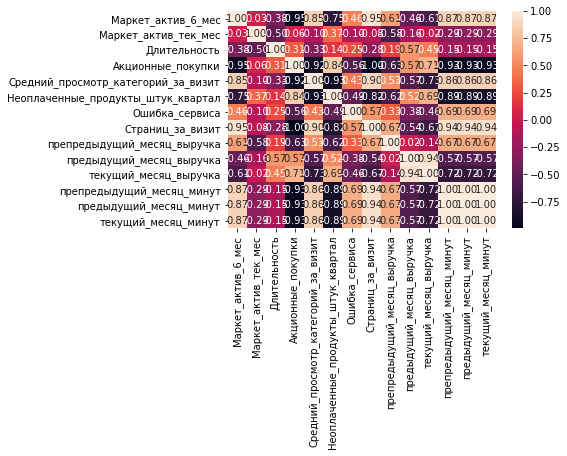

<Figure size 2160x2160 with 0 Axes>

In [48]:
cor = data_full[
    [
        'Маркет_актив_6_мес',
        'Маркет_актив_тек_мес',
        'Длительность',
        'Акционные_покупки',
        'Средний_просмотр_категорий_за_визит',
        'Неоплаченные_продукты_штук_квартал',
        'Ошибка_сервиса',
        'Страниц_за_визит',
        'препредыдущий_месяц_выручка',
        'предыдущий_месяц_выручка',
        'текущий_месяц_выручка',
        'препредыдущий_месяц_минут',
        'предыдущий_месяц_минут',
        'текущий_месяц_минут'
    ]
].corr()
sns.heatmap(cor.corr('spearman'), annot = True, fmt = '.2f')
plt.figure(figsize=(30, 30))

In [49]:
data_for_an = data_full

data_full = data_full.drop('препредыдущий_месяц_выручка', axis = 1)

data_full = data_full.drop('id', axis = 1)

**На этом этапе мы итсеяли признаки с высокой зависимость друг от друга. Т.к мультиколлинеарность плохо влияет на модель, из-за чего та становится необъективной и начинает игнорировать одни признаки в пользу других, которые могут привести её к ложным ответам**

In [50]:
data_full = data_full.dropna()

In [51]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1295 entries, 0 to 7768
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская_активность            1295 non-null   object 
 1   Тип_сервиса                          1295 non-null   object 
 2   Разрешить_сообщать                   1295 non-null   object 
 3   Маркет_актив_6_мес                   1295 non-null   float64
 4   Маркет_актив_тек_мес                 1295 non-null   int64  
 5   Длительность                         1295 non-null   int64  
 6   Акционные_покупки                    1295 non-null   float64
 7   Популярная_категория                 1295 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1295 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1295 non-null   int64  
 10  Ошибка_сервиса                       1295 non-null   int64  
 11  Страниц_за_визит              

In [52]:
data_full.head(10)

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,препредыдущий_месяц_минут,текущий_месяц_минут
0,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,6586.2,27.0,27.0,27.0
6,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,10432.0,9943.2,22.0,22.0,22.0
12,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,10915.0,10116.8,21.0,21.0,21.0
18,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,12316.0,13220.8,24.0,24.0,24.0
24,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,11615.0,11745.0,19.0,19.0,19.0
30,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,9477.0,10777.0,20.0,20.0,20.0
36,Снизилась,стандарт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2,11370.0,11739.2,23.0,23.0,23.0
42,Снизилась,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4,6526.0,7545.2,22.0,22.0,22.0
48,Снизилась,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3,8293.0,9132.8,13.0,13.0,13.0
54,Снизилась,стандарт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5,0.0,11972.6,18.0,18.0,18.0


**Удалили мультиколлинеарность признаков**

In [53]:
data_full_ml = data_full
data_full_ml['Покупательская_активность'] = data_full['Покупательская_активность'].replace(['Снизилась','Прежний уровень'],[0,1])

In [54]:
RANDOM_STATE = 42
TEST_SIZE = 0.25


X_train, X_test, y_train, y_test = train_test_split(
    data_full_ml.drop('Покупательская_активность', axis=1),
    data_full_ml['Покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = data_full['Покупательская_активность'])

X_train.shape, X_test.shape

ohe_columns = ['Тип_сервиса', 'Разрешить_сообщать','Популярная_категория']
num_columns = [
    'Маркет_актив_6_мес',
    'Маркет_актив_тек_мес',
    'Длительность',
    'Акционные_покупки',
    'Средний_просмотр_категорий_за_визит',
    'Неоплаченные_продукты_штук_квартал',
    'Ошибка_сервиса',
    'Страниц_за_визит',
    'текущий_месяц_выручка',
    'текущий_месяц_минут',
    'предыдущий_месяц_выручка',
    'предыдущий_месяц_минут',
    'препредыдущий_месяц_минут'
]

In [55]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

In [56]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler1', MinMaxScaler()),
    ('scaler2', StandardScaler())
])

In [57]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
).set_output(transform='pandas')

In [58]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

**Построили пайплайны для обработки данных**


In [59]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [num_pipe]  
    },
    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 4),
        'preprocessor__num': [num_pipe]   
    },

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [num_pipe]  
    }
]

In [60]:
grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1
)
grid.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid.best_score_)
y_test_pred = grid.predict(X_test)
y_pred_prob = grid.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_pred_prob)}')
best_model = grid.best_estimator_.get_params()['models']
preprocessor = grid.best_estimator_.named_steps['preprocessor']

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Тип_сервиса',
                                                   'Разрешить_сообщать',
                                                   'Популярная_категория']),
                        

**По итогам самой лучшей моделью оказалась логистическая регрессия. Балы выбрана метрика ROC-AUC, т.к нам надо знать на сколько правильно модель предсказывает классы**

**Метрика ROC-AUC выбрана т.к в наших данных присутсвует дисбаланс классов, а она более устойчива к ним, чем метрика f1. Плюс ко всему ROC-AUC позволяет более надежно сравнивать качество различных моделей**

In [61]:
X_train_processed = data_preprocessor.fit_transform(X_train)
X_test_processed = data_preprocessor.transform(X_test)

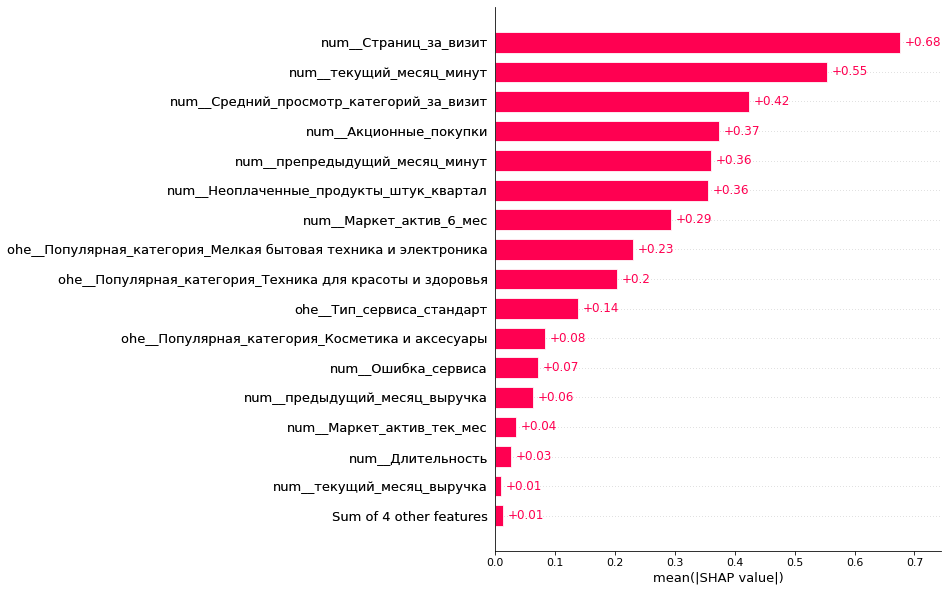

In [62]:
explainer = shap.LinearExplainer(best_model, X_test_processed)
shap_values = explainer(X_test_processed)
shap.plots.bar(shap_values, max_display=17)

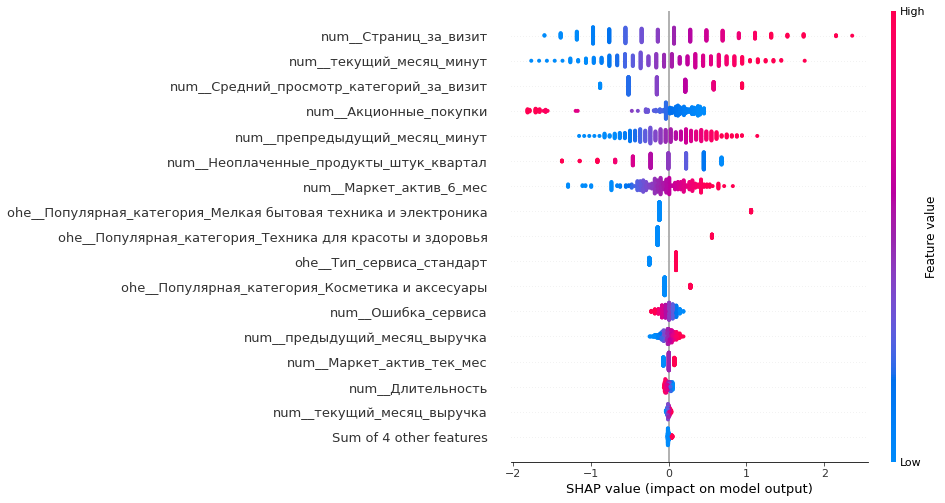

In [63]:
explainer = shap.LinearExplainer(best_model, X_test_processed)
shap_values = explainer(X_test_processed)
shap.plots.beeswarm(shap_values, max_display=17)

**Если проанализировать этот график, то можно заметить, что акционные покупки существенно влияют на покупатльскую активность. Судя по всему, люди начали чаще покупать по акциям, и перестали покупать неакционные покупки, из-за чего произошло такое смещение графика**

**Сильнее всего на модель влияет кол-во проведённого времени на сайте в минутах, кол-во посещённых страниц и акционные покупки, меньше всего же в свою очередь влияет Кол-во дней с момента регистрации и выбор клиента разрешать сообщать о новиниках и акциях или же нет**

**СЕГМЕНТАЦИЯ**

 Анализ для категории: Товары для детей 


/tmp/ipykernel_225/4088951739.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_category = X_test_processed[mask]


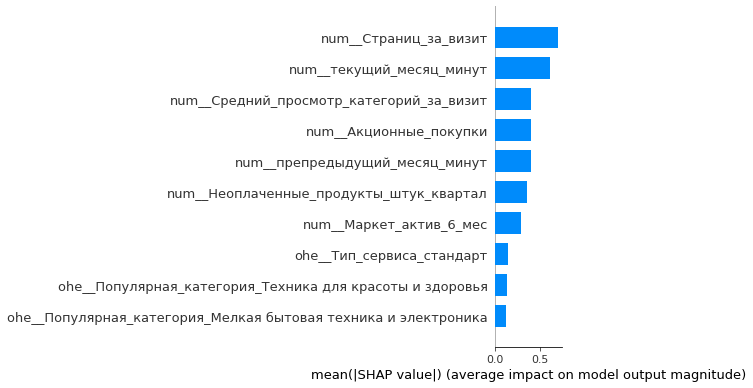

 Анализ для категории: Домашний текстиль 


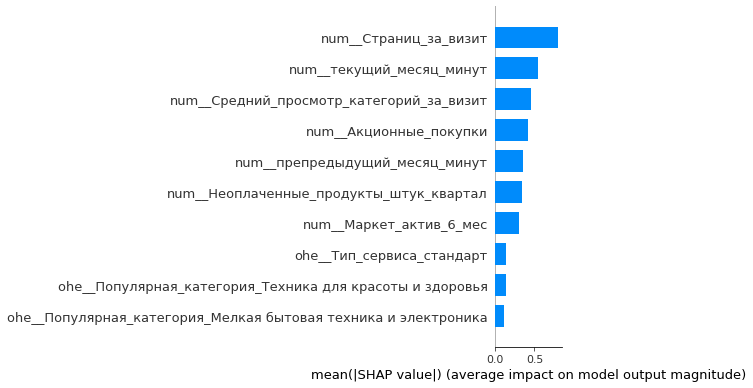

 Анализ для категории: Косметика и аксесуары 


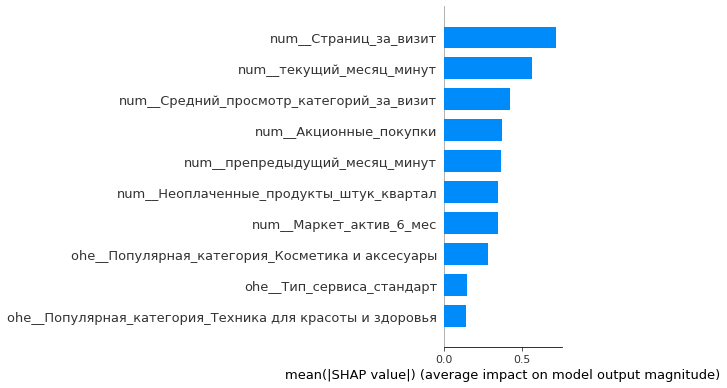

 Анализ для категории: Техника для красоты и здоровья 


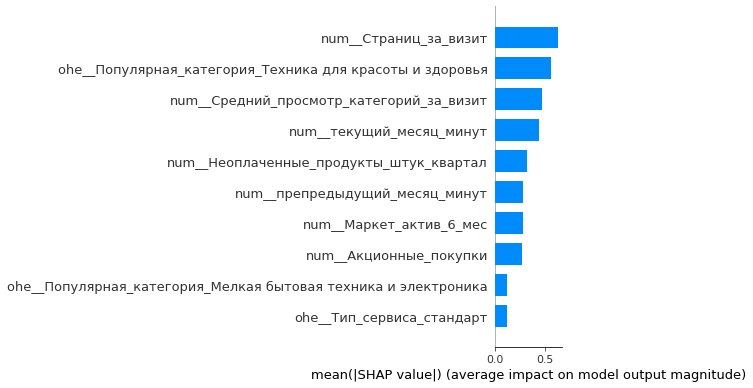

 Анализ для категории: Кухонная посуда 


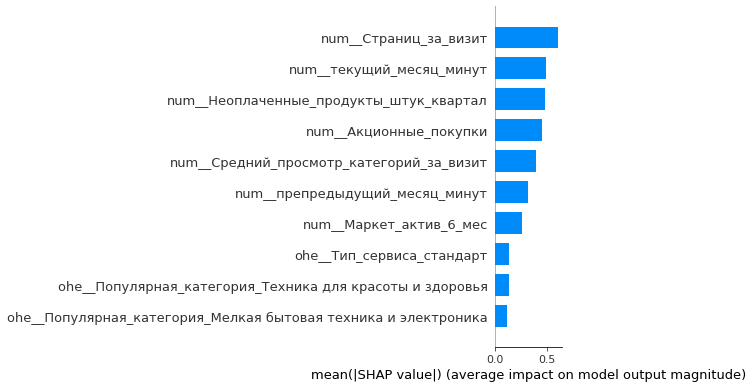

 Анализ для категории: Мелкая бытовая техника и электроника 


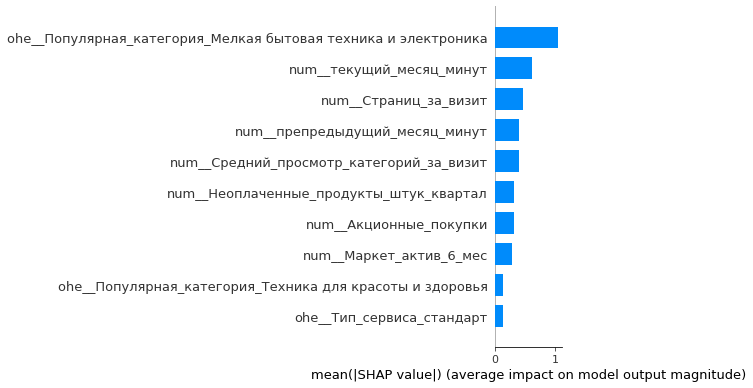

In [64]:
for category in data_full['Популярная_категория'].unique():
    print(f" Анализ для категории: {category} ")

    mask = data_full['Популярная_категория'] == category
    X_category = X_test_processed[mask]

    explainer = shap.Explainer(best_model, X_test_processed)
    shap_values = explainer(X_category)

    shap.summary_plot(shap_values, X_category, plot_type="bar", max_display=10)
    plt.show()

**В категории: Товары для детей наиболее важным является акционные покупки и средний просмотр категорий за визит (текущий кол-во минут проведённых на сайте не рассматриваем, т.к это явный признак важный для всех категорий), для них предлагаю чаще показывать акционные предложения, уведомлять о них и предлагать больше категорий для просмотра, возможно уменьшим окна категорий во вкладке товары для детей.**

**В категории: Домашний текстиль так же наиболее важным является акционные покупки и средний просмотр категорий за визит, для них предложение аналогично верхнеё категории чаще показывать акционные предложения, уведомлять о них и предлагать больше категорий для просмотра, возможно уменьшим окна категорий во вкладке.**

**В категории: Косметика и аксесуары - аналогично.**

**А вот с категорией Кухонная посуда всё намного интересней, для них не мало значит лежащие в корзине товары, которые они могут забывать оплатить. Для них можно ввести систему уведомлений о неоплачнных товарах в корзине**

**Техника для красоты и здоровья - аналогично для первых двух**

**Мелкая бытовая техника и электроника - Им стоит чаще предлагать товары их наиболее покупаемой категории**



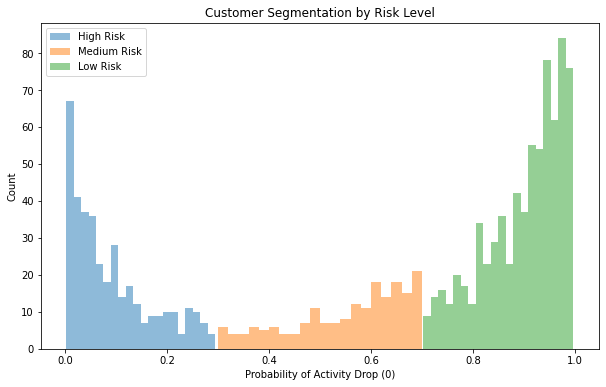

In [65]:
threshold_low = 0.3
threshold_high = 0.7
X_full_processed = preprocessor.transform(data_full_ml.drop('Покупательская_активность', axis=1))
probas_full = best_model.predict_proba(X_full_processed)[:, 1]
segments_full = np.where(probas_full < threshold_low, "high_risk",
                       np.where(probas_full < threshold_high, "medium_risk", "low_risk"))
data_full_ml['risk_segment'] = segments_full
data_full_ml['probability'] = probas_full


segments = np.where(probas_full < threshold_low, "high_risk",
                  np.where(probas_full < threshold_high, "medium_risk", "low_risk"))
plt.figure(figsize=(10, 6))
plt.hist(probas_full[segments_full == "high_risk"], bins=20, alpha=0.5, label='High Risk')
plt.hist(probas_full[segments_full == "medium_risk"], bins=20, alpha=0.5, label='Medium Risk')
plt.hist(probas_full[segments_full == "low_risk"], bins=20, alpha=0.5, label='Low Risk')
plt.xlabel('Probability of Activity Drop (0)')
plt.ylabel('Count')
plt.title('Customer Segmentation by Risk Level')
plt.legend()
plt.show()

**По этому графику мы можем понять примерное соотношение сегментов с разными уровнями риска. Я выделил 3 из них, те у кого высокий риск понизить свою покупательскую активность средний и низкие риски соответсвтенно. Большее число покупателей имеют небольшие риски уйти в низкую активность.**


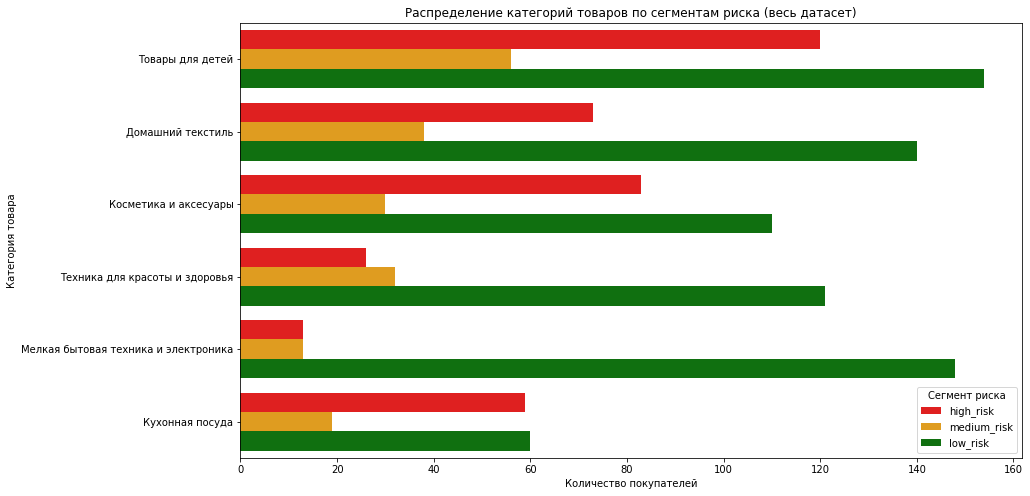

In [66]:
plt.figure(figsize=(14, 8))
sns.countplot(
    data=data_full_ml,
    y='Популярная_категория',
    hue='risk_segment',
    order=data_full_ml['Популярная_категория'].value_counts().index,
    hue_order=['high_risk', 'medium_risk', 'low_risk'],
    palette={'high_risk': 'red', 'medium_risk': 'orange', 'low_risk': 'green'}
)
plt.title('Распределение категорий товаров по сегментам риска (весь датасет)')
plt.xlabel('Количество покупателей')
plt.ylabel('Категория товара')
plt.legend(title='Сегмент риска')
plt.show()

**Почти наравне по соотношению покупателей с высоким / низким риском - это товары для детей, косметика и акссесуары и кухонная посуда. У остальных же прослеживается что покупателей с низким риском значительно меньше, чем с высоким. Значит можно сосредоточиться на небольшой выборке "рисковых" покупателей**

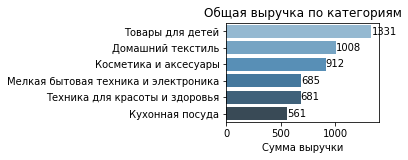

<Figure size 1440x1080 with 0 Axes>

In [67]:
data_an = pd.merge(data_for_an, data_money, on='id', how='inner')

category_revenue = data_an.groupby('Популярная_категория')['Прибыль'].agg(
    total=('sum'),
).sort_values('total', ascending=False)

plt.subplot(2, 2, 1)
ax1 = sns.barplot(
    data=category_revenue.reset_index(),
    x='total',
    y='Популярная_категория',
    palette='Blues_d',
    estimator=sum
)
plt.title('Общая выручка по категориям')
plt.xlabel('Сумма выручки')
plt.ylabel('')
plt.figure(figsize=(20, 15))
ax1.bar_label(ax1.containers[0], fmt='%.0f');

**По этому графику мы модем заметить, что основную часть прибыли приносит категория "Товары для детей", в которой и собралось значительное кол-во "рисковых клиентов". На втором месте "домашний текстиль", у него всё значительно лучше с распределением рисков. На третьем месте Косметика и аксессуары. Значит 2 из 6 категорий имеют высокие риски перестать покупать нашу продукцию и при этом они входят в тройку самых прибыльных категорий. На них и нужно сконцентрировать своё внимание.**

**Мы уже выяснили, что является ключевым фактором для каждой из категорий. Рассмотрев детально графики влияния признаков на каждую из них могу предложить следующие варианты решения:**
  
**1)На многих сильно влияет кол-во просмотренных страниц за визит сайта, поэтому имеет смысл представлять попкупателям большее кол-во товаров на странице сайта. Так же возможно стоит поработать над дизайном сайта, чтобы он был более приятный или функциональный, чтобы покупатели дольше на нём задерживались. Может имеет смысл сделать "предложку", где будет подбираться наиболее просматриваемые товары, на некоторых ресурсах это так же называют "вам может быть интересно".**

**2)Для категории "товары для детей" показывать больше продуктов на странице, так же настроить автонапоминание им о том, что у них в корзине лежит неоплаченный товар, который они хотели купить. Настроить уведомления о акционных товарах или чаще показывать их в ленте покупателей**

**3)Для категории "Косметика и аксессуары" в топ-3 стоит неоплаченные товары в корзине и в топ-5 активность маркетинга. Можно увеличить кол-во взаимодействий маркетинга с покупателями и в эти взаимодействия добавить напоминание о неоплаченных товарах в корзине**

**ВЫВОД:**

**Мы провели анализ данных, выбрали покупателей, которые проявляли активность за последние 3 месяца и на этих данных построили и обучили модель МО при помощи пайплайнов и метрик выбрали саму лучшую из них и благодаря этому смогли понять, какие признаки сильнее всего влияют на покупателей, и на покупателей отдельных категорий в частности. Смогли разобраться, какие категории приносят больше прибыли и какие из них находятся под "риском". Теперь можно построить бизнес-план в соответсвтии с моими рекомендациями для удержания постоянных клиентов.**

**Мы выяснили, что на покупательскую активность сильнее всего влияет Кол-во просмотренных страниц и категорий за сеанс, а так же длительность нахождения на сайте.**

**Самые сильные потери среди покупателей наблюдаются за категориями "товары для детей", "косметика и аксессуары" и "кухонная посуда"**

**Самую высокую выручку же приносят "товары для детей", "домашний текстиль" и "косметика и аксессуары".**